In [15]:
%matplotlib inline
# All required dependencies for all plots 
import aplpy
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.units as u
from NOEMAsetup import *
from spectral_cube import SpectralCube
from ChauvenetRMS import *
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.visualization import AsinhStretch
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.patches import Ellipse, Rectangle

In [2]:
def plot_aplpy_standard(image, stretch, vmin, vmax, cmap, phasecent=[ra_Per50, dec_Per50], radiusplot= 16/3600,vmid=0.01, figsize=(4,4), label_col='w', star_col='r'):
    fig = aplpy.FITSFigure(image, figsize=figsize)
    if stretch=='arcsinh':
        fig.show_colorscale(stretch=stretch, cmap=cmap, vmin=vmin, vmax=vmax, vmid=vmid)
    else:
        fig.show_colorscale(stretch=stretch, cmap=cmap, vmin=vmin, vmax=vmax)
    fig.add_colorbar()
    setup_plot_noema(fig, label_col=label_col, star_col=star_col)
    fig.recenter(phasecent[0], phasecent[1], radiusplot)
    fig.beam.set_color('k')
    fig.beam.set_frame(True)
    fig.scalebar.set_linewidth(2)
    return fig

### H2CO integrated moment plot

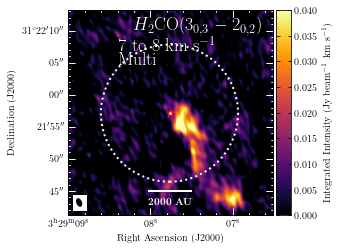

In [26]:
saveaction = 0
contourplot = 0
regionplot = 0

folder = 'H2CO/CDconfig/'
filename = H2CO_303_202
cleanalg = 'Multi'
stretch = 'linear'
moment = 0
velinit = 7 #km/s
velend = 8 #km/s
savefile = folder + 'H2CO_'+cleanalg+'_'+str(velinit)+'to'+str(velend)+'_'+stretch+'_moment'+str(moment)+'_SMAbeam.pdf'
vmin = 0
vmax = 0.04
vmid = 0.01
cmap = 'inferno'
radiusplot = 18/3600
title = r'$H_{2}$CO($3_{0,3}-2_{0,2}$)\\'+str(velinit)+' to '+str(velend)+r' km s$^{-1}$\\'+cleanalg

contourfile = 'SO_55_44/Per-emb-50_C_l009l048_cont.fits'
contourfile2 = filename+'.fits'
contlevels = [0.007]
regions = folder +'spectra_regs.reg'

cube = SpectralCube.read(filename+'.fits')
cube = cube.with_spectral_unit(u.km/u.s)
headercube = cube.hdu.header
freq = headercube['RESTFREQ'] * u.Hz
phasecent = [headercube['ra'], headercube['dec']]

subcube = cube.spectral_slab(velinit*u.km/u.s, velend*u.km/u.s)
moment0 = subcube.moment(order=moment).hdu
rms = calculatenoise(moment0.data)[0]
if contourplot:
    contourfile = SpectralCube.read(contourfile)
    contourfile = contourfile[0,:,:]
    contourfile2 = SpectralCube.read(contourfile2).with_spectral_unit(u.km/u.s)
    contour2 = contourfile2.spectral_slab(velinit*u.km/u.s, velend*u.km/u.s).moment(order=moment).hdu
    rms2 = calculatenoise(contour2.data)[0]


fig = plot_aplpy_standard(moment0, stretch, vmin, vmax, cmap)
fig.colorbar.set_axis_label_text(r'Integrated Intensity (Jy beam$^{-1}$ km s$^{-1}$)')
fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='w', lw=2)
if contourplot:
    fig.show_contour(contour2, levels=[rms2*3, rms2*5], colors='w')
if regionplot:
    fig.show_regions(regions)
fig.add_label(0.95,0.85, title, color='white',
               relative=True, horizontalalignment='right', size=18)
fig.scalebar.set_label(r'\textbf{2000 AU}')

if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)


## Noise plots


### H2CO

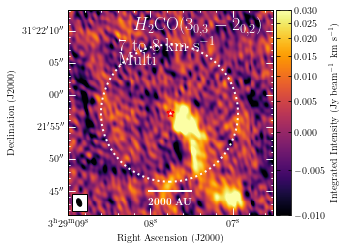

In [27]:
saveaction = 0
contourplot = 0
regionplot = 0

folder = 'H2CO/CDconfig/'
filename = H2CO_303_202
cleanalg = 'Multi, C+D config'
stretch = 'arcsinh'
moment = 0
velinit = 7 #km/s
velend = 8 #km/s
savefile = folder + 'H2CO_'+cleanalg+'_'+str(velinit)+'to'+str(velend)+'_'+stretch+'_moment'+str(moment)+'.pdf'
vmin = -0.01
vmax = 0.03
vmid = 0.001
cmap = 'inferno'
radiusplot = 18/3600
title = r'$H_{2}$CO($3_{0,3}-2_{0,2}$)\\'+str(velinit)+' to '+str(velend)+r' km s$^{-1}$\\'+cleanalg

contourfile = 'SO_55_44/Per-emb-50_C_l009l048_cont.fits'
contourfile2 = filename+'.fits'
contlevels = [0.007]
regions = folder +'spectra_regs.reg'

cube = SpectralCube.read(filename+'.fits')
cube = cube.with_spectral_unit(u.km/u.s)
headercube = cube.hdu.header
freq = headercube['RESTFREQ'] * u.Hz
phasecent = [headercube['ra'], headercube['dec']]

subcube = cube.spectral_slab(velinit*u.km/u.s, velend*u.km/u.s)
moment = subcube.moment(order=moment).hdu
rms = calculatenoise(moment0.data)[0]
if contourplot:
    contourfile = SpectralCube.read(contourfile)
    contourfile = contourfile[0,:,:]
    contourfile2 = SpectralCube.read(contourfile2).with_spectral_unit(u.km/u.s)
    contour2 = contourfile2.spectral_slab(velinit*u.km/u.s, velend*u.km/u.s).moment(order=moment).hdu
    rms2 = calculatenoise(contour2.data)[0]


fig = plot_aplpy_standard(moment, stretch, vmin, vmax, cmap, vmid=vmid)
fig.colorbar.set_axis_label_text(r'Integrated Intensity (Jy beam$^{-1}$ km s$^{-1}$)')
fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='w', lw=2)
if contourplot:
    fig.show_contour(contour2, levels=[rms2*3, rms2*5], colors='w')
if regionplot:
    fig.show_regions(regions)
fig.add_label(0.95,0.85, title, color='white',
               relative=True, horizontalalignment='right', size=18)
fig.scalebar.set_label(r'\textbf{2000 AU}')

if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)
